# Test old vs new remeshing ->  REAL CASE

In [1]:
import rasterio
import shutil
import rasterio.plot
import rasterio.warp
from rasterio.crs import CRS
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import avaframe.in3Utils.fileHandlerUtils as fU
import avaframe.in2Trans.rasterUtils as IOf
import subprocess
import configparser
import avaframe.in2Trans.rasterUtils as rU
%load_ext autoreload
%autoreload 2
import avaframe.in3Utils.geoTrans as geoTrans

In [2]:
def getXCoords(src,data):

    height, width = data.shape #Find the height and width of the array

    #Two arrays with the same shape as the input array/raster, where each value is the x or y index of that cell
    cols, rows = np.meshgrid(np.arange(width), np.arange(height)) 

    #Two arrays with the same shape as the input array/raster, where each value is the x or y coordinate of that cell 
    xs, ys = rasterio.transform.xy(src.transform, rows, cols) 

    #They are actually lists, convert them to arrays
    xcoords = np.array(xs[0])
    ycoords = np.array(ys)

    return xcoords

# Get reference solution raster

In [16]:
solRaster = '/home/felix/Versioning/AvaFrame/avaframe/tests/data/remeshedDEM8.00.asc'
dataSol = IOf.readRaster(solRaster)

avaDir = pathlib.Path('./RTest')
demToRemesh = '/home/felix/Versioning/AvaFrame/avaframe/tests/../data/avaParabola/Inputs/DEM_PF_Topo.asc'
avaDEM = avaDir / "Inputs" / "DEM_PF_Topo.asc"
shutil.copy(demToRemesh, avaDEM)

PosixPath('RTest/Inputs/DEM_PF_Topo.asc')

## Remesh

In [21]:
cfg = configparser.ConfigParser()
cfg["GENERAL"] = {
    "meshCellSizeThreshold": "0.0001",
    "meshCellSize": 8,
    "avalancheDir": str(avaDir),
}

pathDem = geoTrans.remeshRaster(avaDEM, cfg, legacy=False)
fullP = avaDir / "Inputs" / pathDem
print(fullP)
dataNew = IOf.readRaster(fullP)
#subprocess.run(["head", "-n7", fullP])

{'ncols': 626, 'nrows': 251, 'cellsize': 8.0, 'xllcenter': 1000.0, 'yllcenter': -5000.0, 'nodata_value': 'nan', 'crs': None, 'driver': 'AAIGrid', 'transform': Affine(8.0, 0.0, 996.0,
       0.0, -8.0, -2996.0)}
RTest/Inputs/remeshedRasters/DEM_PF_Topo_remeshedDEM8.00.asc


## Plotting the differences

In [23]:
oldRaster = dataSol
newRaster = rU.readRaster(fullP)
#print(oldRaster["header"])
#print(newRaster["header"])
#subprocess.run(["head", "-n7", fullP])
#subprocess.run(["head", "-n7", fullPNew])

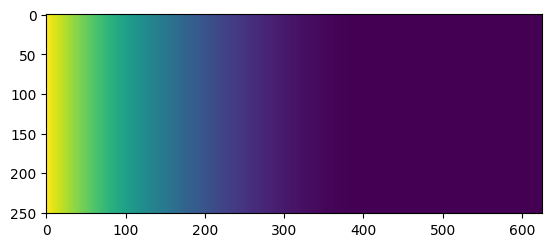

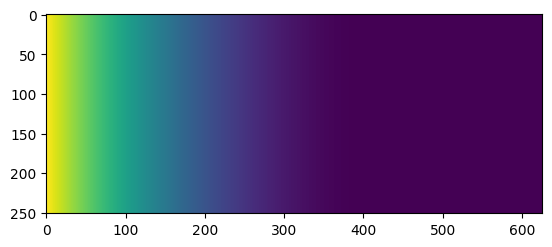

<Axes: >

In [24]:
rasterio.plot.show(oldRaster['rasterData'])
rasterio.plot.show(newRaster['rasterData'])

<Axes: title={'center': 'New Remesh'}>

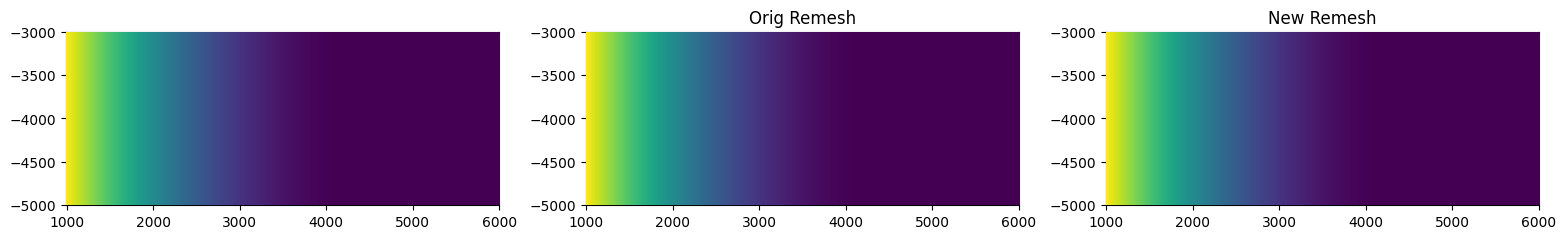

In [28]:
srcOrigDEM = rasterio.open(avaDEM, 'r')
dataOrigDEM = srcOrigDEM.read(1)
origX = getXCoords(srcOrigDEM, dataOrigDEM)

srcOrigRemesh = rasterio.open(solRaster, 'r')
dataOrigRemesh = srcOrigRemesh.read(1)
origRemeshX = getXCoords(srcOrigRemesh,dataOrigRemesh)

srcNewRemesh = rasterio.open(fullP, 'r')
dataNewRemesh = srcNewRemesh.read(1)
dataNewRemesh = np.where(dataNewRemesh == srcNewRemesh.nodata, np.nan, dataNewRemesh)
newX = getXCoords(srcNewRemesh,dataNewRemesh)



# Plot the GeoTIFF
#fig, ax = plt.subplots(figsize=(10, 10))
fig, (axorig, axOrigRemesh,axNew) = plt.subplots(1, 3, figsize=(19,8))
#axorig.set_title("OrigDEM")
#axorig.set_xlim([-5, 20])
#axorig.set_ylim([-5, 25])
#axorig.hlines([-2.5,22.5],-5,20)
#axorig.vlines([-2.5,17.5],-5,25)
axorig.grid()
axOrigRemesh.set_title("Orig Remesh")
#axOrigRemesh.set_xlim([-5, 20])
#axOrigRemesh.set_ylim([-5, 25])
#axOrigRemesh.hlines([-2.5,22.5],-5,20)
#axOrigRemesh.vlines([-2.5,17.5],-5,25)
axOrigRemesh.grid()
axNew.set_title("New Remesh")
#axNew.set_xlim([-5, 20])
#axNew.set_ylim([-5, 25])
#axNew.hlines([-2.5,22.5],-5,20)
#axNew.vlines([-2.5,17.5],-5,25)
axNew.grid()

rasterio.plot.show(dataOrigDEM, transform=srcOrigDEM.transform, ax=axorig, alpha=1, cmap="viridis", zorder=5)
rasterio.plot.show(dataOrigRemesh, transform=srcOrigRemesh.transform, ax=axOrigRemesh, alpha=1, cmap="viridis", zorder=5)
rasterio.plot.show(dataNewRemesh, transform=srcNewRemesh.transform, ax=axNew, alpha=1, cmap="viridis", zorder=5)


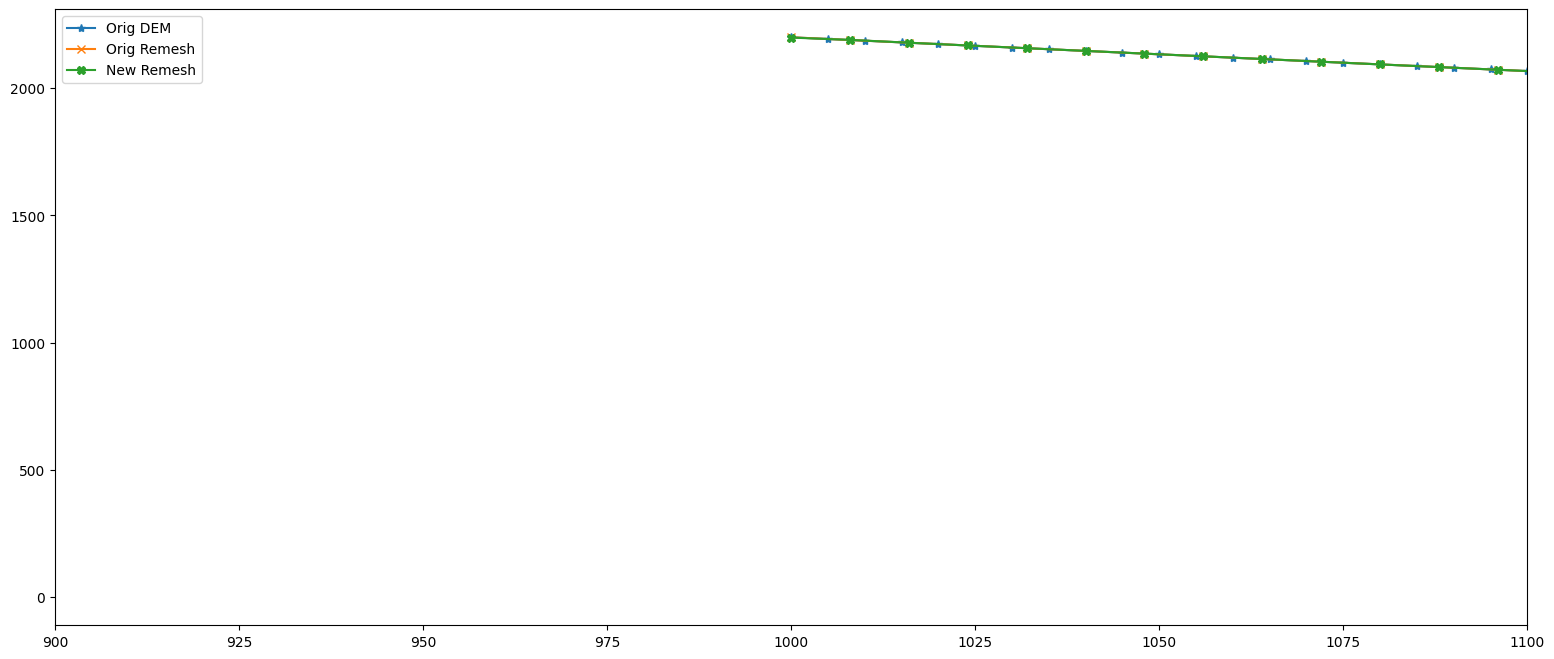

In [31]:
fig2, ax2 = plt.subplots(figsize=(19,8))
profOrig = dataOrigDEM[1,:]
profOldRe = dataOrigRemesh[1,:]
profNewRe = dataNewRemesh[1,:]
ax2.set_xlim([900,1100])
plt.plot(origX,profOrig,'-*',label="Orig DEM")
plt.plot(origRemeshX,profOldRe,'-x',label="Orig Remesh")
plt.plot(newX,profNewRe,'-X',label='New Remesh')
ax2.legend()

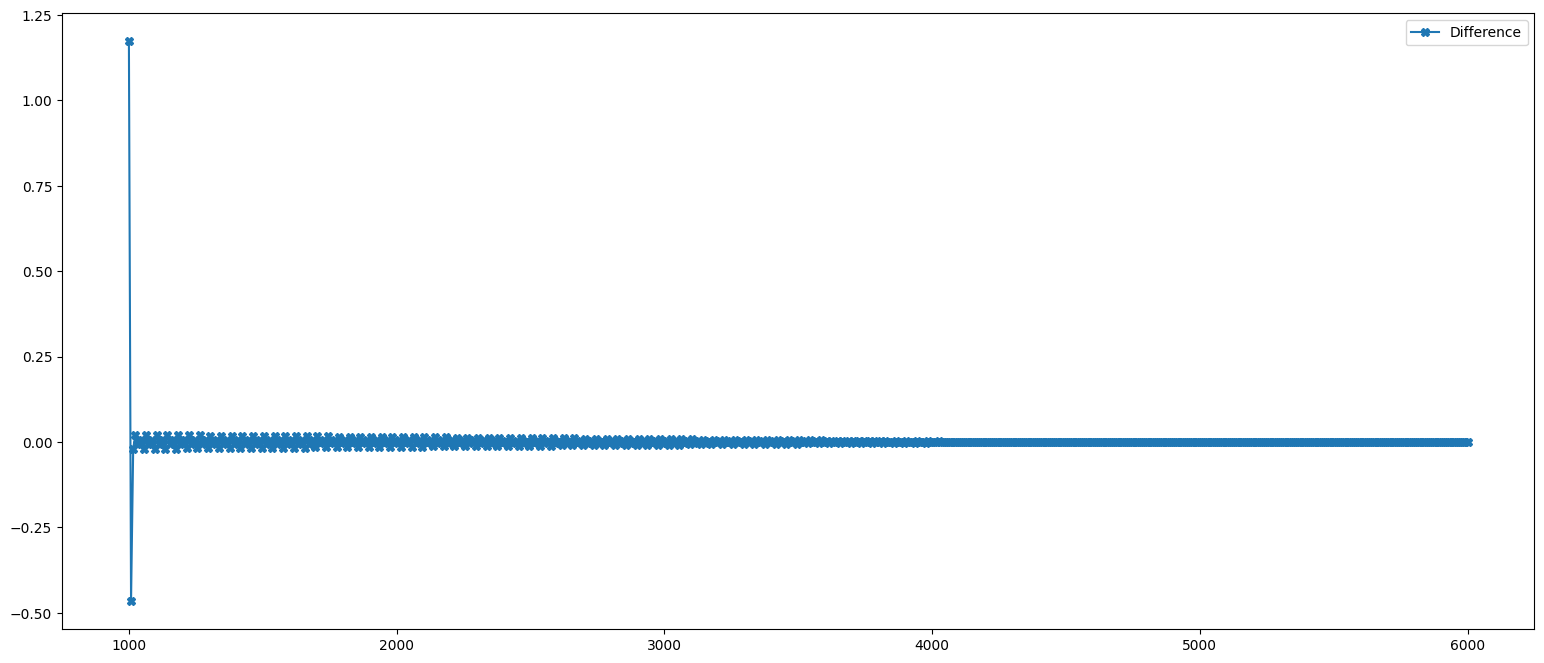

In [32]:
fig2, ax2 = plt.subplots(figsize=(19,8))
#profOrig = dataOrigDEM[1,:]
profOldRe = dataOrigRemesh[1,:]
profNewRe = dataNewRemesh[1,:]
profDiff = profOldRe - profNewRe
plt.plot(newX,profDiff,'-X',label='Difference')
ax2.legend()